# Práctico 5 - Procesamiento Digital de Imágenes

In [46]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import convolve2d

%matplotlib inline

In [47]:
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.596,-0.275,-0.321],
                        [0.211,-0.523, 0.311]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

def rmse(img1, img2):
    return np.sqrt(np.mean((img1-img2)**2))

In [48]:
from matplotlib import cm

def plot_kernel(data, ax=None):
    rows, cols = data.shape
    y, x = np.meshgrid(np.arange(rows),np.arange(cols),indexing='ij')
    if ax == None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    _min, _max = (np.min(data), np.max(data))
    ax.plot_surface(x, y, data.T, cmap=cm.jet, vmin=_min, vmax=_max)

def plot_images_and_kernel(img, img_filt, kernel):
    fig = plt.figure(figsize=(17,5))
    ax1 = fig.add_subplot(131)
    ax1.imshow(img, 'gray')
    ax1.title.set_text('Input image')
    ax2 = fig.add_subplot(132)
    ax2.imshow(img_filt, 'gray')
    ax2.title.set_text('Filtered image')
    ax3 = fig.add_subplot(133, projection='3d')
    plot_kernel(kernel, ax=ax3)
    ax3.title.set_text('Kernel')
    plt.show()

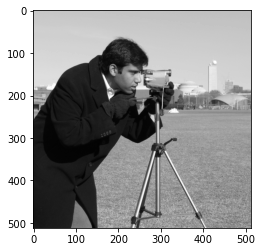

In [49]:
img = imageio.imread('imageio:camera.png')/255
plt.imshow(img, 'gray')

# 1. Filtros convolucionales

Para cada uno de los siguientes incisos implementar una función que devuelva el kernel en función de los parámetros especificados. Luego convolucionar la imagen con el kernel y utilizar la función plot_images_and_kernel() para graficar el resultado.

### 1.1. Implementar los siguientes filtros simétricos (invariantes a la rotación de 90°)

Pasabajos: Los kernels tendrán que ser del tamaño especificado por el usuario. Todos son de NxN donde N es impar.

1. Box (cuadrado) -> params: N
2. Circle (circular) -> params: N
3. Bartlett -> params: N
4. Gaussian -> params: N, std

Pasaaltos:

5. Laplace (4 y 8 vecinos) -> params: neighbors (entero que vale 4 u 8)
6. Pasaaltos a partir de un pasabajos: PA = Id - PB -> params: los mismos que el pasabajos elegido

Pasabanda:

7. Difference of Gaussian (DoG) -> params: N, std1, std2

Otros:

8. Mejora de contraste (combinación del filtro identidad más "un poco" de pasaaltos) -> params: los del pasaaltos y la constante de proporción de pasaaltos sumado

### 1.2. Implementar los siguientes filtros direccionales (asimétricos)

9. Sobel 3x3 -> Calcular valor absoluto de gradientes Gx y Gy y también en módulo y fase. Para graficar la fase, normalizar al rango [0,1] y utilizar un mapa de colores que no sea escala de grises.

### 1.3. Implementar un detector de bordes a partir del filtro de Sobel

Aplicar un umbral al módulo del filtro de Sobel para obtener una imagen binaria con 1s en los bordes y 0s en el resto

### 1.4. Escribir una breve descripción sobre cómo funciona el detector de bordes de Canny

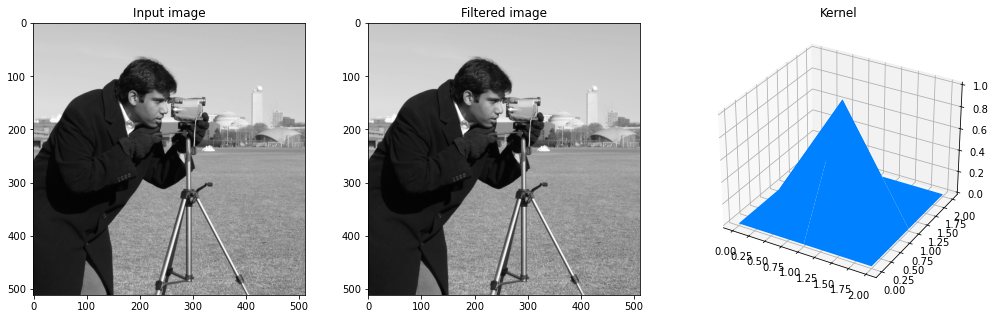

In [50]:
# Ejemplo del kernel identidad
kernel = np.zeros((3,3))
kernel[1,1] = 1
kernel /= kernel.sum()

img_filt = convolve2d(img, kernel, 'same')

plot_images_and_kernel(img, img_filt, kernel)

## 1. Box (cuadrado) -> params: N

In [51]:
#Filtro Cuadrado
N=5
kernel = np.ones((N,N))
kernel /= kernel.sum()

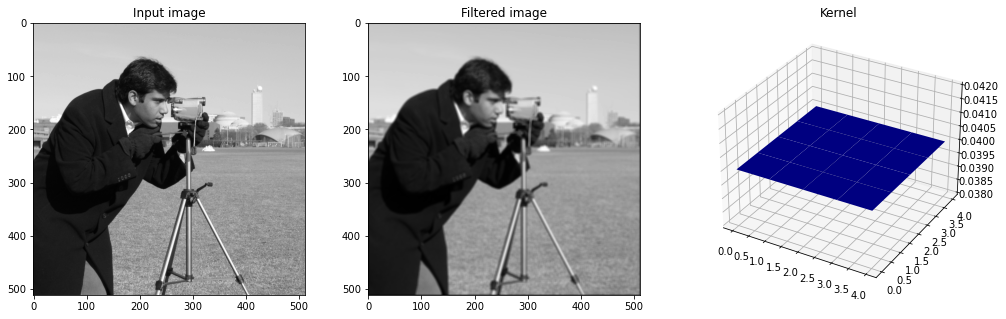

In [52]:
img_filt = convolve2d(img, kernel, 'same')
plot_images_and_kernel(img, img_filt, kernel)

## 2. Circle (circular) -> params: N

In [53]:
# Calcular distancIa circulares
import math
N=5
kernel = np.zeros((N,N))
medio = np.floor(N/2)
print(medio)
for i in range(N):
    for j in range(N) :
        distancia = ((i-medio)*(i-medio)+ (j-medio)*(j-medio))**(0.5) 
        if distancia <= medio :
                    kernel[i,j] =1
        else :
                    kernel[i,j] =0
print(kernel)
                

2.0
[[0. 0. 1. 0. 0.]
 [0. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 0.]]


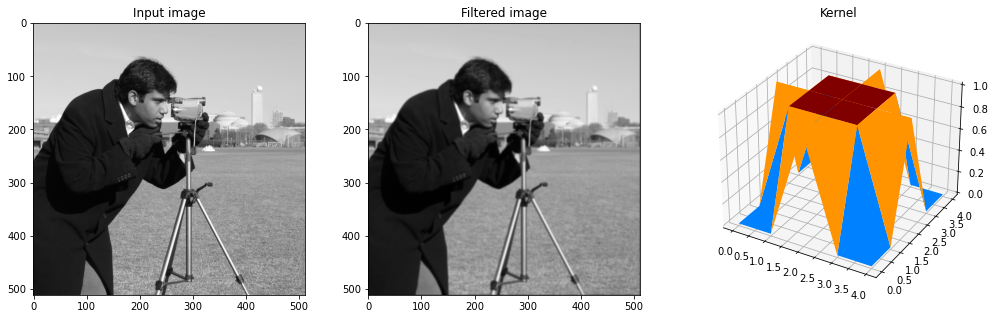

In [54]:
img_filt = convolve2d(img, kernel, 'same')
plot_images_and_kernel(img, img_filt, kernel)

## 3. Bartlett -> params: N

In [55]:
#Filtro Bartlet
N=5
vectkernel = np.zeros(N)
medio = np.floor(N/2)
r = 0
for fila in range(N):
    if fila <= medio:
        vectkernel[fila] = (r+1)
        r =r+1
    else:
        vectkernel[fila] = (r-1)
        r = r-1   
print(vectkernel)
kernel=vectkernel.reshape(-1,1)*vectkernel ## producto de vector-columna*vector-fila
print(kernel)
kernel /= kernel.sum()


[1. 2. 3. 2. 1.]
[[1. 2. 3. 2. 1.]
 [2. 4. 6. 4. 2.]
 [3. 6. 9. 6. 3.]
 [2. 4. 6. 4. 2.]
 [1. 2. 3. 2. 1.]]


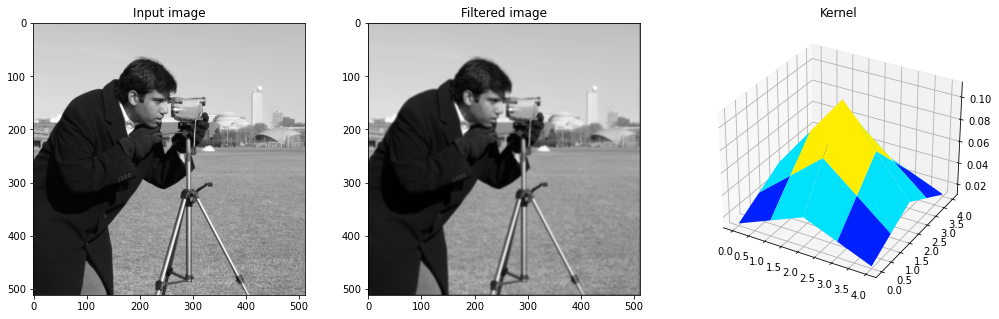

In [56]:
img_filt = convolve2d(img, kernel, 'same')
plot_images_and_kernel(img, img_filt, kernel)

## 4. Gaussian -> params: N, std

In [57]:
## Gausian metodo 
N=5
## Funcion Para kernel Gausianno
#triangulo pascal
def Kernel_Gau(N):
    x=np.zeros(N)
    fila=[1]
    y = [0]
    for x in range(max(N-1,0)):      
        fila=[left+right for left,right in zip(fila+y, y+fila)]
    x=np.array(fila) # convertir el arreglo a vector
    kernel=x.reshape(-1,1)*x ## producto de vector-columna*vector-fila
    suma= kernel.sum()
    kernel=kernel/suma
    return kernel

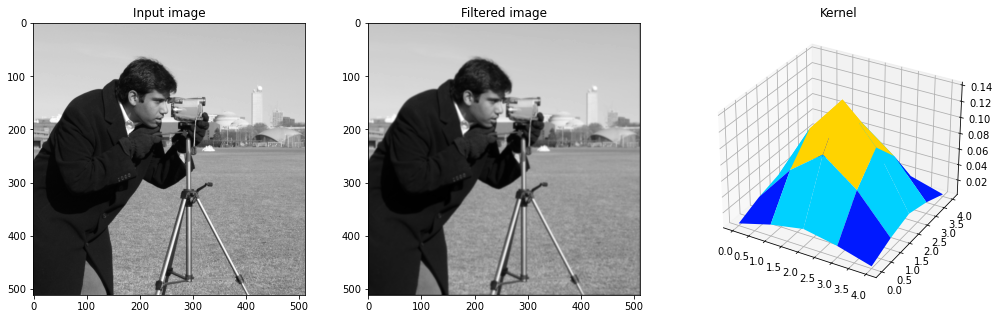

In [58]:
kernel=Kernel_Gau(N)
img_filt = convolve2d(img, kernel, 'same')
plot_images_and_kernel(img, img_filt, kernel)

## Pasaaltos:
## Laplace (4 y 8 vecinos) -> params: neighbors (entero que vale 4 u 8)

[[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]


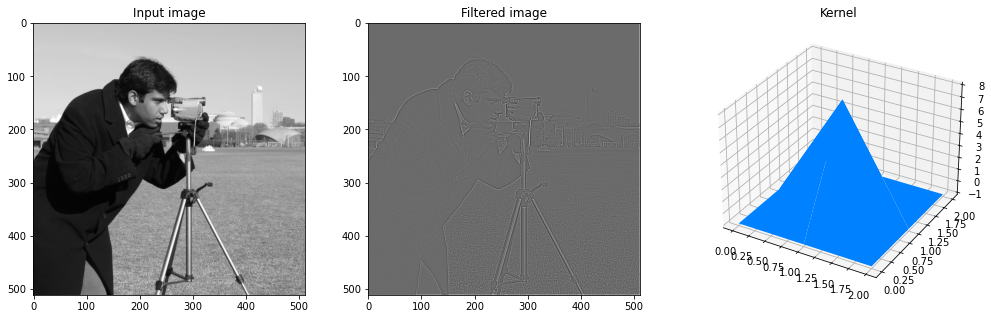

In [59]:
vecino=8
if vecino == 4:
        kernel = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
if vecino == 8:
        kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
print(kernel)
img_filt = convolve2d(img, kernel, 'same')
plot_images_and_kernel(img, img_filt, kernel)

## 6. Pasaaltos a partir de un pasabajos: PA = Id - PB -> params: los mismos que el pasabajos elegido

In [60]:
N=7
#Filtro Identidad
kernel_Id = np.zeros((N,N))
medio = math.floor(N/2)
kernel_Id[medio,medio] = 1
print(kernel_Id)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


In [61]:
kernel=Kernel_Gau(N)
#### Aplicando la diferencia
kernel_PA = np.zeros((N,N))
kernel_PA = kernel_Id-kernel

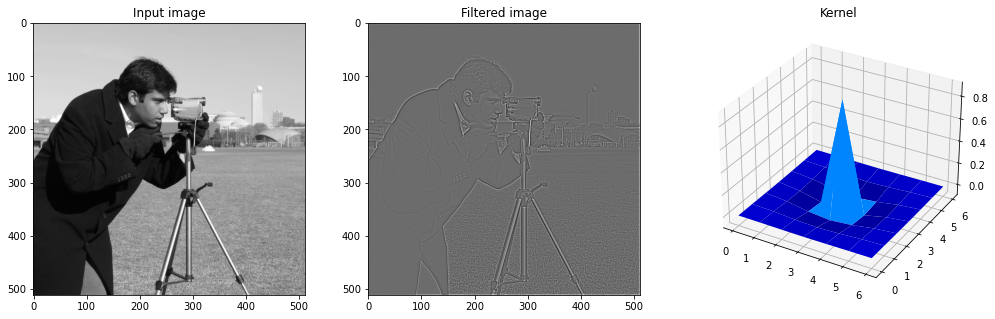

In [62]:
img_filt = convolve2d(img, kernel_PA, 'same')
plot_images_and_kernel(img, img_filt, kernel_PA)

## Pasabanda:
7. Difference of Gaussian (DoG) -> params: N, std1, std2



In [63]:
Kernel_Gau3 = np.zeros((5,5))
Kernel_Gau3[1:4,1:4] = Kernel_Gau(3) #Inserta hernel 3x3 en 5x5 con bordes ceros 
Kernel_Gau5 = Kernel_Gau(5)
Kernel_DoG=Kernel_Gau3-Kernel_Gau5

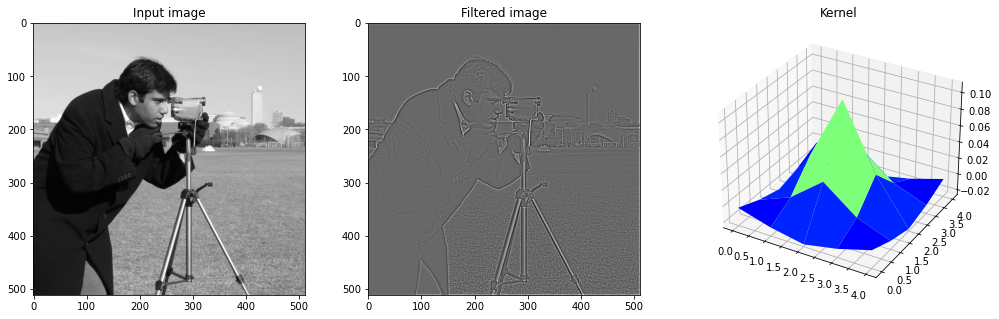

In [64]:
img_filt = convolve2d(img, Kernel_DoG, 'same')
plot_images_and_kernel(img, img_filt, Kernel_DoG)

## Otros:
Mejora de contraste (combinación del filtro identidad más "un poco" de pasaaltos) -> params: los del pasaaltos y la constante de proporción de pasaaltos sumado

In [65]:
N=5
#Filtro Identidad
kernel_Id = np.zeros((N,N))
medio = math.floor(N/2)
kernel_Id[medio,medio] = 1
## Aplicando Mejora de constraste
kernel=Kernel_Gau(N)
kernel_PA = np.zeros((N,N))
kernel_PA = kernel_Id-kernel ## Aplicando la diferencia para obtner Pasa Altos
kernel_MejoraC = np.zeros((N,N))
kernel_MejoraC = kernel_Id+0.2*kernel_PA ## Aplicando la suma


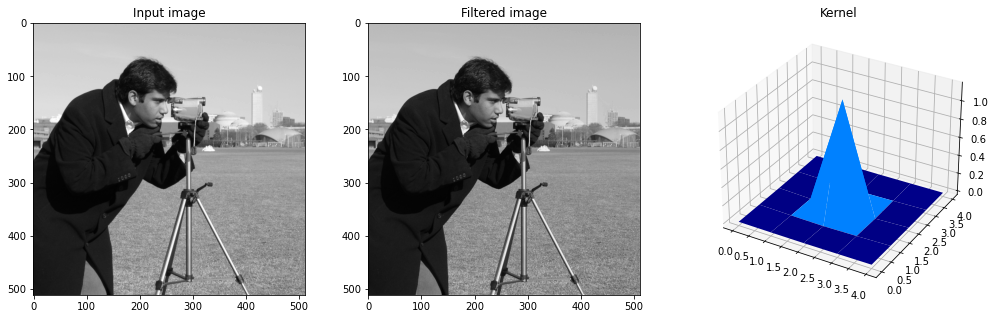

In [66]:
img_filt = convolve2d(img, kernel_MejoraC, 'same')
plot_images_and_kernel(img, img_filt, kernel_MejoraC)

## 1.2. Implementar los siguientes filtros direccionales (asimétricos)
Sobel 3x3 -> Calcular valor absoluto de gradientes Gx y Gy y también en módulo y fase. Para graficar la fase, normalizar al rango [0,1] y utilizar un mapa de colores que no sea escala de grises.

In [67]:
kernel_N = np.array([[-1,-2,-1],[ 0, 0, 0],[ 1, 2, 1]]) ## Kernel Norte
kernel_S =  np.array([[ 1, 2, 1],[ 0, 0, 0],[-1,-2,-1]]) ##Kernel Sur
kernel_E =  np.array([[ 1, 0,-1], [ 2, 0,-2],[ 1, 0,-1]]) ##Kernel Este
kernel_O =  np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])  ##Kernle Oeste